In [1]:
import torch
import pandas as pd
from torch import nn
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from torch.autograd import Variable
from sklearn import metrics
from sklearn.preprocessing import MinMaxScaler
import math, time
from sklearn.metrics import mean_squared_error

In [2]:
import pyro
import pyro.contrib.examples.polyphonic_data_loader as poly
import pyro.distributions as dist
import pyro.poutine as poutine
from pyro.distributions import TransformedDistribution
from pyro.distributions.transforms import affine_autoregressive

In [44]:
from StockPredictorLSTM import StockDataset

In [3]:
import seaborn as sns  # for coloring 

# set style of graphs
plt.style.use('seaborn')
from pylab import rcParams
plt.rcParams['figure.dpi'] = 100

In [4]:
df = pd.read_csv('../../stock/MSFT.csv', parse_dates=True, index_col='Date')
df_train, df_test = train_test_split(df, test_size=0.1, shuffle=False)

In [5]:
len_test = len(df) - int(len(df)*0.2)
df_x = df[:len_test]
df_x.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2021-09-29 00:00:00-04:00,285.100006,286.769989,283.010010,284.000000,280.849762,26353700
2021-09-30 00:00:00-04:00,285.709991,287.829987,281.619995,281.920013,278.792847,32343600
2021-10-01 00:00:00-04:00,282.119995,289.980011,281.290009,289.100006,285.893188,30086300
2021-10-04 00:00:00-04:00,287.399994,287.750000,280.250000,283.109985,279.969604,31350700
2021-10-05 00:00:00-04:00,284.049988,290.399994,284.049988,288.760010,285.556946,24993000


In [6]:
df_test.tail()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-12-06 00:00:00-05:00,250.820007,251.860001,243.779999,245.119995,245.119995,22463700
2022-12-07 00:00:00-05:00,244.830002,246.160004,242.210007,244.369995,244.369995,20481500
2022-12-08 00:00:00-05:00,244.839996,248.740005,243.059998,247.399994,247.399994,22611800
2022-12-09 00:00:00-05:00,244.699997,248.309998,244.160004,245.419998,245.419998,20607100
2022-12-12 00:00:00-05:00,247.449997,252.539993,247.169998,252.509995,252.509995,30650100


In [7]:
class SequenceDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, target, features, sequence_length=5):
        self.features = features
        self.target = target
        self.sequence_length = sequence_length
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i): 
        if i >= self.sequence_length - 1:
            i_start = i - self.sequence_length + 1
            x = self.X[i_start:(i + 1), :]
        else:
            padding = self.X[0].repeat(self.sequence_length - i - 1, 1)
            x = self.X[0:(i + 1), :]
            x = torch.cat((padding, x), 0)

        return x, self.y[i]

In [8]:
target= "Close"
features = ['High', 'Low', 'Open', 'Volume']

In [9]:
target_mean = df_train[target].mean()
target_stdev = df_train[target].std()

for c in df_train.columns:
    mean = df_train[c].mean()
    stdev = df_train[c].std()

    df_train[c] = (df_train[c] - mean) / stdev
    df_test[c] = (df_test[c] - mean) / stdev

In [47]:
stock = StockDataset(df_train, 
            isValSet_bool=True, 
            sequence_length=30,
            test_size=0.2,
            )


30

In [10]:
i = 27
sequence_length = 4

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)

X, y = train_dataset[i]
print(X)

tensor([[-1.2374, -1.2306, -1.2312, -0.6795],
        [-1.2371, -1.2307, -1.2333, -0.8494],
        [-1.2294, -1.2295, -1.2339, -0.4952],
        [-1.2311, -1.2213, -1.2249, -0.8436]])


In [11]:
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True)

X, y = next(iter(train_loader))
print(X.shape)
print(X)

torch.Size([3, 4, 4])
tensor([[[ 9.0789e-02,  1.9643e-03,  1.7684e-02,  3.2727e+00],
         [ 1.1610e-01,  1.3422e-03,  1.2208e-01,  3.3231e+00],
         [ 6.3772e-02,  4.3141e-02,  5.6786e-02,  1.6206e+00],
         [ 6.5841e-02,  4.4012e-02,  2.6783e-02,  1.4651e+00]],

        [[-2.4084e-01, -2.3191e-01, -2.3942e-01,  4.8876e-01],
         [-2.5508e-01, -2.4261e-01, -2.4336e-01, -6.5523e-01],
         [-2.4899e-01, -2.4087e-01, -2.5024e-01, -8.1821e-01],
         [-2.4984e-01, -2.3838e-01, -2.3328e-01, -3.4253e-01]],

        [[-6.2954e-01, -6.1843e-01, -6.2109e-01, -7.6948e-01],
         [-6.2990e-01, -6.2565e-01, -6.1703e-01, -6.4378e-01],
         [-6.2990e-01, -6.2739e-01, -6.3548e-01, -5.3208e-01],
         [-6.3453e-01, -6.3585e-01, -6.2490e-01, -5.6654e-01]]])


In [12]:
torch.manual_seed(101)

batch_size = 4
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([4, 30, 4])
Target shape: torch.Size([4])


In [13]:
batch_iter = list(enumerate(train_loader))
for batch_ndx, batch_tup in batch_iter:
    print(batch_ndx, batch_tup)

0 [tensor([[[ 1.0085,  1.0274,  1.0291, -0.5561],
         [ 1.0429,  1.0619,  1.0319, -0.5912],
         [ 1.0623,  1.1031,  1.0808, -0.8799],
         [ 1.0646,  1.1022,  1.0766, -0.8747],
         [ 1.0468,  1.0835,  1.0734, -0.3565],
         [ 1.0541,  1.0874,  1.0713, -0.8358],
         [ 1.0445,  1.0550,  1.0742, -0.4509],
         [ 1.0199,  1.0411,  1.0360, -0.7473],
         [ 0.9843,  1.0058,  1.0003, -0.2878],
         [ 1.0489,  1.0619,  1.0315, -0.2899],
         [ 1.0786,  1.0905,  1.0588, -0.4613],
         [ 1.1020,  1.1241,  1.1225, -0.5100],
         [ 1.0961,  1.1328,  1.1059, -0.8617],
         [ 1.1196,  1.1385,  1.1118, -0.3458],
         [ 1.1322,  1.1751,  1.1573, -0.7790],
         [ 1.1499,  1.1774,  1.1562, -0.7673],
         [ 1.1504,  1.1884,  1.1792, -0.8538],
         [ 1.1576,  1.1478,  1.1746, -0.1389],
         [ 1.1718,  1.1676,  1.1337, -0.1120],
         [ 1.1785,  1.2017,  1.1774,  0.6384],
         [ 1.1934,  1.1914,  1.1798, -0.1797],
         [

In [14]:
class LSTM(nn.Module):
    def __init__(self, input_dim=4, hidden_dim=32, num_layers=2, output_dim=1, dropout=0.2):
        super().__init__()
        self.input_dim = input_dim  # this is the number of features
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).requires_grad_()
        
        _, (hn, _) = self.lstm(x, (h0, c0))
        x = self.dropout(x)
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [15]:
model = LSTM(input_dim=4, hidden_dim=32, num_layers=2, output_dim=1)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

In [16]:
torch.optim.Adam(model.parameters(), lr=0.01)

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    eps: 1e-08
    foreach: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [41]:
batch_iter = enumerate(train_loader)
len(train_loader)

337

In [18]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    
    for X, y in enumerate(train_loader):
        output = model(y[0])
        loss = loss_function(output, y[1])

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

'''
def test_model(data_loader, model, loss_function):
    
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
'''

num_epochs = 10
for t in range(num_epochs):
    train_model(train_loader, model, loss_function, optimizer=optimizer)

Train loss: 0.02294517176552595
Train loss: 0.0032171043299098995
Train loss: 0.0015387235170634269
Train loss: 0.0012410095647979304
Train loss: 0.0013918227825278138
Train loss: 0.0010390566069654274
Train loss: 0.0018526219404256335
Train loss: 0.0011440111024764927
Train loss: 0.002623220303516717
Train loss: 0.0010033843420188


In [19]:
def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output


y_pred = predict(test_loader, model)
y_pred = y_pred * target_stdev + target_mean

In [20]:
y_test = (df_test['Close'] * target_stdev + target_mean).values

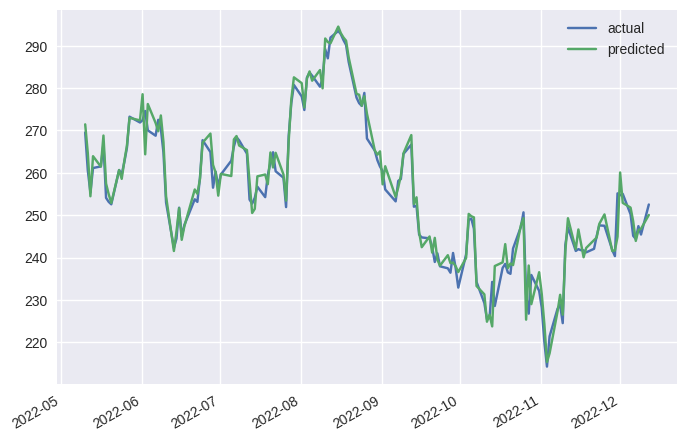

In [21]:
test_data = df_test[0: len(df_test)]
days = np.array(test_data.index, dtype="datetime64[ms]")
actual_close_prices = test_data['Close']
 
fig = plt.figure()
 
axes = fig.add_subplot(111)
axes.plot(days, y_test, label="actual") 
axes.plot(days, y_pred, label="predicted")
 
fig.autofmt_xdate()
 
plt.legend()
plt.show()

In [22]:
testScore = math.sqrt(mean_squared_error(y_test, y_pred))
print('Test Score: %.2f RMSE' % (testScore))

Test Score: 3.13 RMSE
